In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
from skactiveml.utils import MISSING_LABEL
from skactiveml.pool import RandomSampling, TypiClust, GreedySamplingX, CoreSet, ProbCover, DiscriminativeAL, SubSamplingWrapper, ParallelUtilityEstimationWrapper, UncertaintySampling
from sklearn.multioutput import MultiOutputClassifier
from skactiveml.classifier import SklearnMultilabelClassifier, SklearnMultilabelMissingClassClassifier, SklearnClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from utils_metrics import topk_accuracy, cmAP

import matplotlib.pyplot as plt
import torch

In [69]:
import warnings
#mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

In [86]:
X_train, y_train = torch.load("/home/mwirth/projects/scikit-activeml/data/HSN/1/train.pth", weights_only=False)
X_test, y_test = torch.load("/home/mwirth/projects/scikit-activeml/data/HSN/1/test.pth", weights_only=False)
X_train = X_train.numpy()
y_train = y_train.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

In [88]:
y_train.sum(axis=0).astype(int)

array([ 583, 2105,  730,   22,  648,    1,  120,   26,  225,   26,   11,
          3,  255,  112,   15,    0,    3,   61,    7,    7,    7])

In [89]:
y_test.sum(axis=0).astype(int)

array([ 88, 571, 352,   0,  87,   0,  55,   2,  95,   1,   6,   0,  11,
        14,   3,   1,   0,   1,   0,   0,   0])

In [78]:
y_train.sum(axis=0).astype(int)

array([ 533, 2197,  742,   12,  591,    0,  159,   24,  306,   24,   16,
          0,  266,  126,   18,    1,    3,   62,    7,    7,    7])

In [79]:
y_test.sum(axis=0).astype(int)

array([138, 479, 340,  10, 144,   1,  16,   4,  14,   3,   1,   3,   0,
         0,   0,   0,   0,   0,   0,   0,   0])

In [40]:
clf = SklearnMultilabelMissingClassClassifier(MultiOutputClassifier(LogisticRegression()), classes=np.unique(y_train))
qs = UncertaintySampling()
y = np.full(shape=y_train.shape, fill_value=MISSING_LABEL)
init_pool = RandomSampling(random_state=0).query(X=X_train, y=y, batch_size=10)

y[init_pool] = y_train[init_pool]
clf.fit(X_train, y)

for c in range(1):
    query_idx = qs.query(X=X_train, y=y, batch_size=5, clf=clf)
    print(query_idx)
    y[query_idx] = y_train[query_idx]
    clf.fit(X_train, y)


missing 19 labels


TypeError: only integer scalar arrays can be converted to a scalar index

In [43]:
clf = MultiOutputClassifier(LogisticRegression())

class_sums = y_train.sum(axis=0).astype(int)
classes_to_keep = np.where(class_sums > 0)[0]

cmap_met = cmAP(num_labels=y_train[:, classes_to_keep].shape[-1])

clf.fit(X_train[:, classes_to_keep], y_train[:, classes_to_keep])

y_pred = clf.predict_proba(X_test[:, classes_to_keep])
y_pred = np.column_stack([probs[:, 1] for probs in y_pred])

best_acc = topk_accuracy(y_pred, y_test[:, classes_to_keep])
best_cmap = cmap_met(torch.tensor(y_pred), torch.tensor(y_test[:, classes_to_keep]).int())
best_acc, best_cmap

(0.5624461670973299, tensor(0.0884))

In [42]:
best_acc, best_cmap = 0, 0

In [182]:
n_cycles = 15
batch_size = 10
seeds = 1
dataset_name = "HSN"

strategy_accuracies = {}
strategy_cmaps = {}

for seed in range(seeds):
    strategies = {
        'RandomSampling': RandomSampling(random_state=seed),
        # "UncertaintySampling_ent_max": UncertaintySampling(method="entropy", random_state=seed, ml_agg=np.nanmax), # only works with an init pool atm
        # "UncertaintySampling_ent_sum": UncertaintySampling(method="entropy", random_state=seed, ml_agg=np.nansum), # only works with an init pool atm
        "UncertaintySampling_les_max": UncertaintySampling(method="least_confident", random_state=seed, ml_agg=np.max), # only works with an init pool atm
        "UncertaintySampling_les_sum": UncertaintySampling(method="least_confident", random_state=seed, ml_agg=np.sum), # only works with an init pool atm
        #'TypiClust': TypiClust(random_state=seed),
        #"GSx": GreedySamplingX(random_state=seed),
        #"CoreSet": CoreSet(random_state=seed),
        #"ProbCover": ProbCover(random_state=seed),
        #"DAL": DiscriminativeAL(random_state=seed),
    }
    if len(strategy_accuracies) == 0:
        strategy_accuracies = {name: [] for name in strategies.keys()}
        strategy_cmaps = {name: [] for name in strategies.keys()}

    for fold in range(5):
        X_train, y_train = torch.load(f"/home/mwirth/projects/scikit-activeml/data/{dataset_name}/{fold}/train.pth", weights_only=False)
        X_test, y_test = torch.load(f"/home/mwirth/projects/scikit-activeml/data/{dataset_name}/{fold}/test.pth", weights_only=False)
        X_train = X_train.numpy()
        y_train = y_train.numpy()
        X_test = X_test.numpy()
        y_test = y_test.numpy()

        cmap_metric = cmAP(num_labels=y_train.shape[-1])

        for name, qs in strategies.items():
            print("Seed", seed,"Fold:", fold, "Name:", name)

            y_masked = np.full(shape=y_train.shape, fill_value=MISSING_LABEL)
            clf = SklearnMultilabelMissingClassClassifier(
                MultiOutputClassifier(LogisticRegression()), classes=np.arange(y_train.shape[-1]), random_state=seed
            )

            clf1 = SklearnClassifier(LogisticRegression(), classes=2, random_state=seed)

            cmaps = []
            accuracies = []
            init_pool = RandomSampling(random_state=seed).query(X=X_train, y=y_masked, batch_size=10)

            y_masked[init_pool] = y_train[init_pool]
            clf.fit(X_train, y_masked)

            y_pred = clf.predict_proba(X_test)
            accuracy = topk_accuracy(y_pred, y_test)
            accuracies.append(accuracy)
            cmaps.append(cmap_metric(torch.tensor(y_pred), torch.tensor(y_test).int()))


            for c in range(n_cycles):
                #print(name, c)
                if name == "DAL":
                    query_idx = qs.query(X=X_train, y=y_masked, discriminator=clf1, batch_size=batch_size)
                elif name.startswith("UncertaintySampling"):
                    query_idx = qs.query(X=X_train, y=y_masked, clf=clf, fit_clf=True, batch_size=batch_size)
                    #print(query_idx)
                else:
                    query_idx = qs.query(X=X_train, y=y_masked, batch_size=batch_size)

                y_masked[query_idx] = y_train[query_idx]
                clf.fit(X_train, y_masked)

                # eval
                y_pred = clf.predict_proba(X_test)
                accuracy = topk_accuracy(y_pred, y_test)
                accuracies.append(accuracy)
                cmaps.append(cmap_metric(torch.tensor(y_pred), torch.tensor(y_test).int()))

            strategy_accuracies[name].append(accuracies)
            strategy_cmaps[name].append(cmaps)


Seed 0 Fold: 0 Name: RandomSampling
Seed 0 Fold: 0 Name: UncertaintySampling_les_max
Seed 0 Fold: 0 Name: UncertaintySampling_les_sum
Seed 0 Fold: 0 Name: TypiClust
Seed 0 Fold: 0 Name: GSx
Seed 0 Fold: 0 Name: CoreSet
Seed 0 Fold: 1 Name: RandomSampling
Seed 0 Fold: 1 Name: UncertaintySampling_les_max
Seed 0 Fold: 1 Name: UncertaintySampling_les_sum
Seed 0 Fold: 1 Name: TypiClust
Seed 0 Fold: 1 Name: GSx
Seed 0 Fold: 1 Name: CoreSet
Seed 0 Fold: 2 Name: RandomSampling
Seed 0 Fold: 2 Name: UncertaintySampling_les_max
Seed 0 Fold: 2 Name: UncertaintySampling_les_sum
Seed 0 Fold: 2 Name: TypiClust
Seed 0 Fold: 2 Name: GSx
Seed 0 Fold: 2 Name: CoreSet
Seed 0 Fold: 3 Name: RandomSampling
Seed 0 Fold: 3 Name: UncertaintySampling_les_max
Seed 0 Fold: 3 Name: UncertaintySampling_les_sum
Seed 0 Fold: 3 Name: TypiClust
Seed 0 Fold: 3 Name: GSx
Seed 0 Fold: 3 Name: CoreSet
Seed 0 Fold: 4 Name: RandomSampling
Seed 0 Fold: 4 Name: UncertaintySampling_les_max
Seed 0 Fold: 4 Name: UncertaintySamplin

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10, 4))

strats = {"T1-Accuracy": strategy_accuracies,
          "cMAP": strategy_cmaps}
marker = [".", 'o', '+', 'x', '*', 'X']
m = len(marker)

for ax, (name, performances) in zip(axes.flatten(), strats.items()):
    for i, (strat, values)  in enumerate(performances.items()):

        mean = np.mean(values[:5], axis=0)
        std = np.std(values[:5], axis=0)
        ax.plot(range(0, n_cycles + 1), mean, marker=marker[i%m], label=strat)

        ax.fill_between(range(0, n_cycles + 1), mean - std, mean + std, alpha=0.3)
        ax.set_ylabel(name)
        ax.set_title(name)

    ax.set_xlabel('Active Learning Cycle')
    ax.grid(True)

fig.suptitle(f"{dataset_name}, 5 folds 1 seeds")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.14),
    ncol=3,
    fontsize="medium",
    frameon=False,
)
plt.tight_layout()
plt.show()

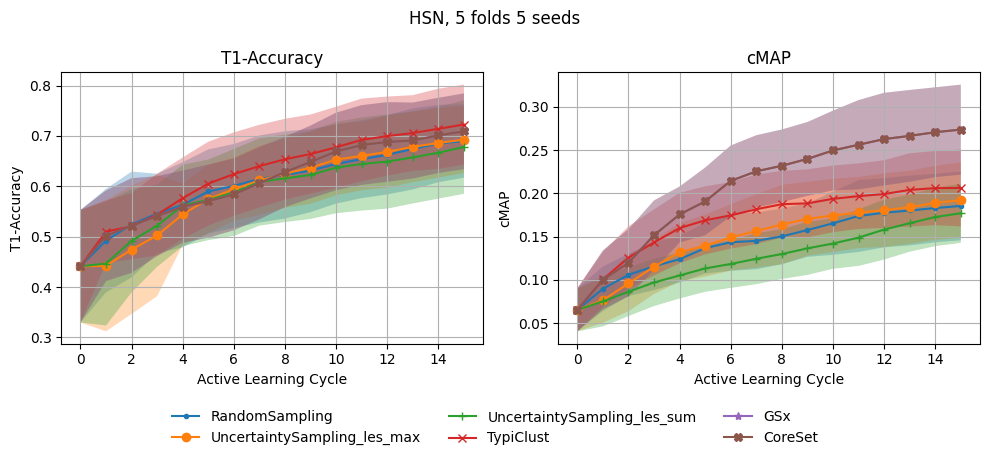

In [198]:
fig, axes = plt.subplots(1,2, figsize=(10, 4))

strats = {"T1-Accuracy": strategy_accuracies,
          "cMAP": strategy_cmaps}
marker = [".", 'o', '+', 'x', '*', 'X']
m = len(marker)

for ax, (name, performances) in zip(axes.flatten(), strats.items()):
    for i, (strat, values)  in enumerate(performances.items()):

        mean = np.mean(values, axis=0)
        std = np.std(values, axis=0)
        ax.plot(range(0, n_cycles + 1), mean, marker=marker[i%m], label=strat)

        ax.fill_between(range(0, n_cycles + 1), mean - std, mean + std, alpha=0.3)
        ax.set_ylabel(name)
        ax.set_title(name)

    ax.set_xlabel('Active Learning Cycle')
    ax.grid(True)

fig.suptitle(f"{dataset_name}, 5 folds 5 seeds")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.14),
    ncol=3,
    fontsize="medium",
    frameon=False,
)
plt.tight_layout()
plt.show()

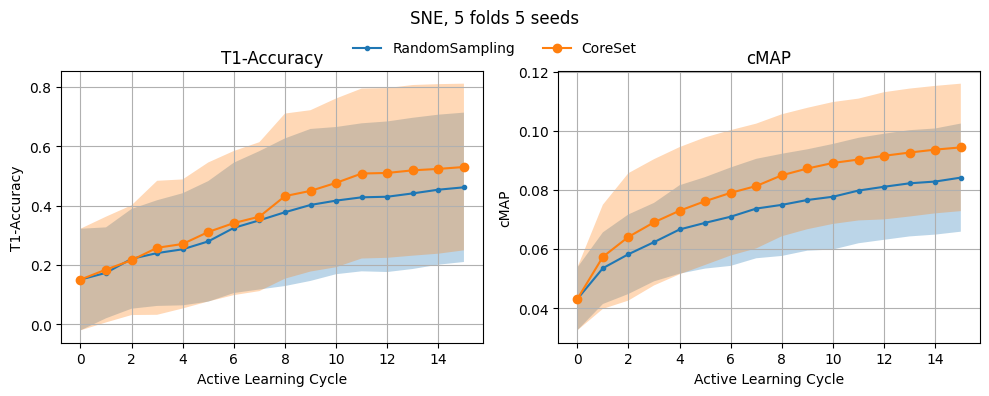

In [179]:
fig, axes = plt.subplots(1,2, figsize=(10, 4))

strats = {"T1-Accuracy": strategy_accuracies,
          "cMAP": strategy_cmaps}
marker = [".", 'o', '+', 'x', '*', '.', 'X']
m = len(marker)

for ax, (name, performances) in zip(axes.flatten(), strats.items()):
    for i, (strat, values)  in enumerate(performances.items()):

        mean = np.mean(values, axis=0)
        std = np.std(values, axis=0)
        ax.plot(range(0, n_cycles + 1), mean, marker=marker[i%m], label=strat)

        ax.fill_between(range(0, n_cycles + 1), mean - std, mean + std, alpha=0.3)
        ax.set_ylabel(name)
        ax.set_title(name)

    ax.set_xlabel('Active Learning Cycle')
    ax.grid(True)

fig.suptitle(f"{dataset_name}, 5 folds 5 seeds")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.93),
    ncol=2,
    fontsize="medium",
    frameon=False,
)
plt.tight_layout()
plt.show()